# Garden map.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import geopandas as gpd
from python import parsers, garden_elements
import contextily as cx


crs  WGS84


## Get kadaster coordinates

Use data downloaded from pdoc.

Get:
- `db_info_percelen` List with properties of each kadaster entry. Only geometry is the midpoint of each kadaster entry.
- `gdf` List with geometries (outlines) of each kadaster field.

Both are converted to crs of choice, default Amersfoort EPSG:28992.

[soort grootte](http://brk.basisregistraties.overheid.nl/id/concept/SoortGrootte): of het vastegesteld is of niet.

In [3]:
# Get list of kadaser objects with generic properies and center point.
db_info_percelen = parsers.get_kadaster_objects(kadastrale_object_ids=parsers.kadastrale_object_ids_own,
                                                file_path = r"./datasets/pdoc_download/kadastralekaart_perceel.gml")

/home/henk/Code/tuin_dynamica/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1750: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)


In [4]:
gdf = [parsers.get_perceel_coordinates(id, as_polygon=False, file_path=r"./datasets/pdoc_download/kadastralekaart_kadastralegrens.gml",) for id in db_info_percelen.index]
gdf = gpd.GeoDataFrame( pd.concat( gdf, ignore_index=False) )
p_origin = parsers.get_lower_left_point_in_veelerveen_rotation(gdf) # Geoseries.

EPSG:28992


## Change to 'Veelerveen coordinates'.
Origin at lower left hand corner, in meters, such that the north side of the land border is horizontal.

In [5]:
# Create Veelerveen crs
lat_min = p_origin.to_crs('WGS84').get_coordinates().y.min()
lon_min = p_origin.to_crs('WGS84').get_coordinates().x.min()
crs_veelerveen = parsers.get_crs_veeleerveen(lat_min, lon_min)

# Convert both kadaster outlines and kadaset database to veelerveen coordinates.
gdf = gdf.to_crs(crs_veelerveen)
db_info_percelen = db_info_percelen.to_crs(crs_veelerveen)

## Add trees and ditches.

In [6]:
# Wilgen lines
p_origin_orchard = np.asarray([74, 2])
wilgen = garden_elements.get_tree_range(4, p_row_start=[3,3], n=[0, 1], tree_distance = 5, crs_local=crs_veelerveen)
wilgen_hor = garden_elements.get_tree_range(5, p_row_start=[3,3], n=[1, 0], tree_distance = 5, crs_local=crs_veelerveen)[1:]
wilgen = pd.concat([wilgen, wilgen_hor])
wilgen = wilgen.reindex()

In [7]:
ditches = []
gdf_ditch_bottom = garden_elements.ditch_geometry(crs_veelerveen, width=1.4,
                           p_start=p_origin_orchard, p_end=np.asarray((185,0)))
gdf_ditch_up = garden_elements.ditch_geometry(crs_veelerveen, width=1.4,
                           p_start=p_origin_orchard, p_end=p_origin_orchard+np.asarray((0, 21)))
gdf_ditch_top = garden_elements.ditch_geometry(crs_veelerveen, width=1.4,
                           p_start=[0, 24.2], p_end=[200,22])


gdf_ditch = pd.concat([gdf_ditch_bottom, gdf_ditch_up, gdf_ditch_top])

In [8]:
tree_ranges_info = [
    {'p_row_start': [8,8], 'tree_distance': 8, 'soort_label': 'appel', 'n': [0, 1]},
    {'p_row_start': [16,8], 'tree_distance': 8, 'soort_label': 'walnoot' , 'n': [0, 1]},
    {'p_row_start': [24,8], 'tree_distance': 7, 'soort_label': 'appel', 'n': [0, 1] },
    {'p_row_start': [32,8], 'tree_distance': 7, 'soort_label': 'kers', 'n': [0, 1] },
    {'p_row_start': [40,8], 'tree_distance': 7, 'soort_label': 'appel', 'n': [0, 1] },
    {'p_row_start': [48,8], 'tree_distance': 7, 'soort_label': 'kers', 'n': [0, 1] },
    {'p_row_start': [32,3], 'tree_distance': 8, 'soort_label': 'pruim', 'n': [1, 0] }, 
]
gdf_fruit = None
for tree_settings in tree_ranges_info:
    gdf_fruit = garden_elements.get_tree_range(2, p_row_start=tree_settings['p_row_start'], n=tree_settings['n'], 
                               tree_distance = tree_settings['tree_distance'],
                               p_origin_orchard=p_origin_orchard, soort_label=tree_settings['soort_label'],
                               df_append=gdf_fruit)

## Plot
- Perceel ID.
- Perceel borders.
- Ditches (gdf_ditch)
- Trees (gdf_fruit, wilgen)

In [9]:
# North annotation
gdf_north = parsers.get_north_arrow(crs_veelerveen, p_shift_x=0, p_shift_y=0)

<Axes: >

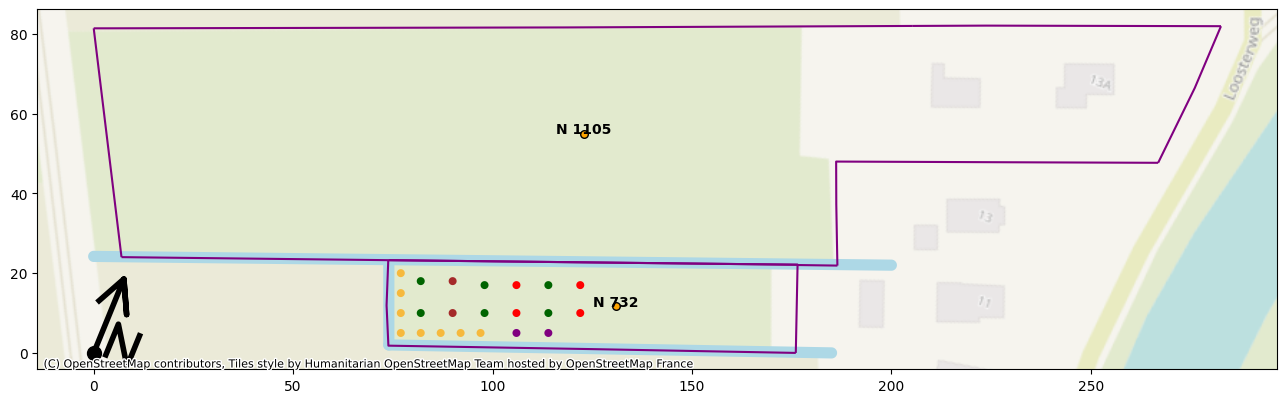

In [10]:
_, ax = plt.subplots(1,1, figsize=(16, 8), squeeze=True)
ax.set_aspect('equal')
ax = gdf.plot(color='purple', edgecolor="black", alpha=1, ax=ax)
ax = db_info_percelen.plot(color='orange', edgecolor="black", alpha=1, ax=ax, markersize=30)
cx.add_basemap(ax, crs=gdf.crs, alpha=.6)
parsers.add_perceel_name(ax, db_info_percelen)

gdf_north.plot(ax=ax, linewidth=4, color='k')

wilgen.plot(ax=ax, color=garden_elements.tree_colors['wilgen'], alpha=0.7)
gdf_ditch.plot(ax=ax, color='lightblue')

for label, df_group in gdf_fruit.groupby('label'):
    df_group.plot(ax=ax, color=garden_elements.tree_colors[label])

p_origin.to_crs(crs_veelerveen).plot(ax=ax, color='black', markersize=100)